<a href="https://colab.research.google.com/github/RyanSaul85/Thinkful/blob/main/Capstone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **About the Data**

* from 2016
* location is Brazil
* 14 columns and 110527 rows

# **Loading Libraries and Data**

In [1]:
import pandas as pd
import numpy as np
import datetime
from time import strftime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
!pip install matplotlib --upgrade
print(matplotlib.__version__)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
3.5.2


In [2]:
url = 'https://raw.githubusercontent.com/RyanSaul85/RyanSaul85/main/KaggleV2-May-2016.csv'

df = pd.read_csv(url)

print('The DataFrame Shape is: {}'.format(df.shape))

The DataFrame Shape is: (110527, 14)


In [3]:
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


# **Data Cleaning**

* Make sure format of data is correct (int, float, object)
* Rename columns
* Change ScheduledDay and AppointmentDay to Datetime
* Get difference between ScheduledDay and AppointmentDay
* Remove values with Age < 0
* Get dummy variables
* Check for null values




In [5]:
df['PatientId'] = df['PatientId'].astype('int64')

In [6]:
df = df.rename(columns = {'PatientId' : 'PatientID', 
                          'Neighbourhood' : 'Neighborhood', 
                          'Hipertension' : 'Hypertension', 
                          'SMS_received' : 'SMSreceived', 
                          'No-show' : 'NoShow', 
                          'Handcap' : 'Handicap'})

In [7]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64')

In [8]:
df['DaysInAdvance'] = df['AppointmentDay'] - df['ScheduledDay']

In [9]:
print(df['AppointmentDay'].head())

0   2016-04-29
1   2016-04-29
2   2016-04-29
3   2016-04-29
4   2016-04-29
Name: AppointmentDay, dtype: datetime64[ns]


In [10]:
print(df['ScheduledDay'].head())

0   2016-04-29
1   2016-04-29
2   2016-04-29
3   2016-04-29
4   2016-04-29
Name: ScheduledDay, dtype: datetime64[ns]


In [11]:
df['DaysInAdvance'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
print(df['DaysInAdvance'].head())

0    0
1    0
2    0
3    0
4    0
Name: DaysInAdvance, dtype: int64


In [12]:
df = df.reindex(columns=['PatientID', 
                         'AppointmentID', 
                         'Gender', 
                         'ScheduledDay', 
                         'AppointmentDay', 
                         'DaysInAdvance', 
                         'Age', 
                         'Neighborhood', 
                         'Scholarship', 
                         'Hypertension', 
                         'Diabetes', 
                         'Alcoholism', 
                         'Handicap', 
                         'SMSreceived', 
                         'NoShow'])

In [13]:
df['DaysInAdvance'] = df['DaysInAdvance'].astype('int64')

In [14]:
df['DaysInAdvance'] = df['DaysInAdvance'].replace('days', '')

In [15]:
df = df[df['Age'] >= 0]

In [16]:
df['Age'].value_counts()

0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
98        6
115       5
100       4
102       2
99        1
Name: Age, Length: 103, dtype: int64

Let's make sure these Age == 0 values don't have Alcoholism or Hypertension so we can assume they are babies.

In [17]:
df[(df['Age'] == 0) & ((df['Hypertension'].astype(int) == 1) | (df['Alcoholism'].astype(int) == 1))]

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,DaysInAdvance,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSreceived,NoShow


There are no patients with Age==0 with Alcoholism or Hypertension so we will assume they are babies.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientID       110526 non-null  int64         
 1   AppointmentID   110526 non-null  int64         
 2   Gender          110526 non-null  object        
 3   ScheduledDay    110526 non-null  datetime64[ns]
 4   AppointmentDay  110526 non-null  datetime64[ns]
 5   DaysInAdvance   110526 non-null  int64         
 6   Age             110526 non-null  int64         
 7   Neighborhood    110526 non-null  object        
 8   Scholarship     110526 non-null  int64         
 9   Hypertension    110526 non-null  int64         
 10  Diabetes        110526 non-null  int64         
 11  Alcoholism      110526 non-null  int64         
 12  Handicap        110526 non-null  int64         
 13  SMSreceived     110526 non-null  int64         
 14  NoShow          110526 non-null  obj

In [19]:
df.nunique()

PatientID          62298
AppointmentID     110526
Gender                 2
ScheduledDay         111
AppointmentDay        27
DaysInAdvance        131
Age                  103
Neighborhood          81
Scholarship            2
Hypertension           2
Diabetes               2
Alcoholism             2
Handicap               5
SMSreceived            2
NoShow                 2
dtype: int64

Let's get dummy variable for Gender, Neighborhood and NoShow

In [20]:
df_dummies = pd.get_dummies(df)

In [21]:
df_dummies.head(2)

,PatientID,AppointmentID,ScheduledDay,AppointmentDay,DaysInAdvance,Age,Scholarship,Hypertension,Diabetes,Alcoholism,...,Neighborhood_SOLON BORGES,Neighborhood_SÃO BENEDITO,Neighborhood_SÃO CRISTÓVÃO,Neighborhood_SÃO JOSÉ,Neighborhood_SÃO PEDRO,Neighborhood_TABUAZEIRO,Neighborhood_UNIVERSITÁRIO,Neighborhood_VILA RUBIM,NoShow_No,NoShow_Yes
0,29872499824296,5642903,2016-04-29,2016-04-29,0,62,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,558997776694438,5642503,2016-04-29,2016-04-29,0,56,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Let's figure out what day of the week the appointments were scheduled on and what day of the week the appointments were scheduled for.

In [22]:
df['ScheduledDay_DOW'] = df['ScheduledDay'].dt.day_name()
df['AppointmentDay_DOW'] = df['AppointmentDay'].dt.day_name()

In [23]:
df.head(10)

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,DaysInAdvance,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSreceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW
0,29872499824296,5642903,F,2016-04-29,2016-04-29,0,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Friday,Friday
1,558997776694438,5642503,M,2016-04-29,2016-04-29,0,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Friday,Friday
2,4262962299951,5642549,F,2016-04-29,2016-04-29,0,62,MATA DA PRAIA,0,0,0,0,0,0,No,Friday,Friday
3,867951213174,5642828,F,2016-04-29,2016-04-29,0,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Friday,Friday
4,8841186448183,5642494,F,2016-04-29,2016-04-29,0,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Friday,Friday
5,95985133231274,5626772,F,2016-04-27,2016-04-29,2,76,REPÚBLICA,0,1,0,0,0,0,No,Wednesday,Friday
6,733688164476661,5630279,F,2016-04-27,2016-04-29,2,23,GOIABEIRAS,0,0,0,0,0,0,Yes,Wednesday,Friday
7,3449833394123,5630575,F,2016-04-27,2016-04-29,2,39,GOIABEIRAS,0,0,0,0,0,0,Yes,Wednesday,Friday
8,56394729949972,5638447,F,2016-04-29,2016-04-29,0,21,ANDORINHAS,0,0,0,0,0,0,No,Friday,Friday
9,78124564369297,5629123,F,2016-04-27,2016-04-29,2,19,CONQUISTA,0,0,0,0,0,0,No,Wednesday,Friday


In [24]:
df = df.reindex(columns=['PatientID', 
                         'AppointmentID', 
                         'Gender', 
                         'ScheduledDay', 
                         'ScheduledDay_DOW', 
                         'AppointmentDay', 
                         'AppointmentDay_DOW', 
                         'DaysInAdvance', 
                         'Age', 
                         'Neighborhood', 
                         'Scholarship', 
                         'Hypertension', 
                         'Diabetes', 
                         'Alcoholism', 
                         'Handicap', 
                         'SMSreceived', 
                         'NoShow'])

In [25]:
df.head(2)

,PatientID,AppointmentID,Gender,ScheduledDay,ScheduledDay_DOW,AppointmentDay,AppointmentDay_DOW,DaysInAdvance,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSreceived,NoShow
0,29872499824296,5642903,F,2016-04-29,Friday,2016-04-29,Friday,0,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,Friday,2016-04-29,Friday,0,56,JARDIM DA PENHA,0,0,0,0,0,0,No


# **Data Visualization**

In this section I am going to do create some graphs, charts and look at correlation patterns within the data. Since the main goal is to predict Show/No Show, everything will be related to that. Some keys factors that I will be looking at include:
* Gender
* DaysInAdvance
* Age
* Neighborhood
* SMSreceived
* AppointmentDay_DOW
* Scholarship


## Total Counts

In [26]:
print(df['NoShow'].value_counts())
print('----------------')
print(df['Scholarship'].value_counts())
print('----------------')
print(df['Hypertension'].value_counts())
print('----------------')
print(df['Diabetes'].value_counts())
print('----------------')
print(df['Alcoholism'].value_counts())
print('----------------')
print(df['SMSreceived'].value_counts())
print('----------------')
print(df['Scholarship'].value_counts())
print('----------------')
print(df['Handicap'].value_counts())

No     88207
Yes    22319
Name: NoShow, dtype: int64
----------------
0    99665
1    10861
Name: Scholarship, dtype: int64
----------------
0    88725
1    21801
Name: Hypertension, dtype: int64
----------------
0    102583
1      7943
Name: Diabetes, dtype: int64
----------------
0    107166
1      3360
Name: Alcoholism, dtype: int64
----------------
0    75044
1    35482
Name: SMSreceived, dtype: int64
----------------
0    99665
1    10861
Name: Scholarship, dtype: int64
----------------
0    108285
1      2042
2       183
3        13
4         3
Name: Handicap, dtype: int64


In [27]:
df.head(10)

,PatientID,AppointmentID,Gender,ScheduledDay,ScheduledDay_DOW,AppointmentDay,AppointmentDay_DOW,DaysInAdvance,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSreceived,NoShow
0,29872499824296,5642903,F,2016-04-29,Friday,2016-04-29,Friday,0,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,Friday,2016-04-29,Friday,0,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29,Friday,2016-04-29,Friday,0,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29,Friday,2016-04-29,Friday,0,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29,Friday,2016-04-29,Friday,0,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,95985133231274,5626772,F,2016-04-27,Wednesday,2016-04-29,Friday,2,76,REPÚBLICA,0,1,0,0,0,0,No
6,733688164476661,5630279,F,2016-04-27,Wednesday,2016-04-29,Friday,2,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3449833394123,5630575,F,2016-04-27,Wednesday,2016-04-29,Friday,2,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,56394729949972,5638447,F,2016-04-29,Friday,2016-04-29,Friday,0,21,ANDORINHAS,0,0,0,0,0,0,No
9,78124564369297,5629123,F,2016-04-27,Wednesday,2016-04-29,Friday,2,19,CONQUISTA,0,0,0,0,0,0,No


Show vs No Show Totals:  [88207 22319]
% Show:     79.81 %
% No Show:  20.19 %


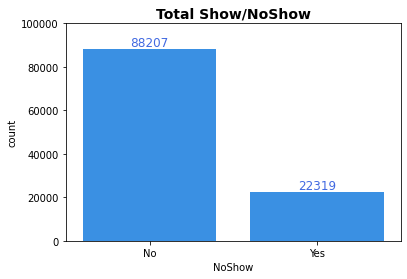

In [100]:
ax = sns.countplot(x = df['NoShow'], color='dodgerblue', order=df['NoShow'].value_counts(ascending=False).index)
ax.set_title('Total Show/NoShow', fontsize=14, fontweight='bold', color='black')
ax.bar_label(ax.containers[0], fontsize=12, color='royalblue')

plt.ylim(0, 100000)

abs_values = df['NoShow'].value_counts(ascending=False).values

print('Show vs No Show Totals: ', abs_values)

print('% Show:    ', round((88207)/(88207+22319)*100,2), '%')
print('% No Show: ', round((22319)/(88207+22319)*100,2), '%')

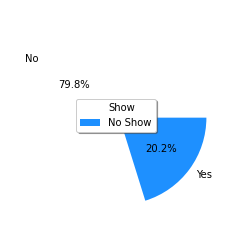

In [29]:
df['NoShow'].value_counts().plot.pie(autopct='%1.1f%%', explode=[0,0.05], colors=['white','dodgerblue'])
#plt.title('Show/No Show')
plt.ylabel('')
plt.xlabel('')

plt.legend(('Show', 'No Show'),shadow=bool, loc=10);

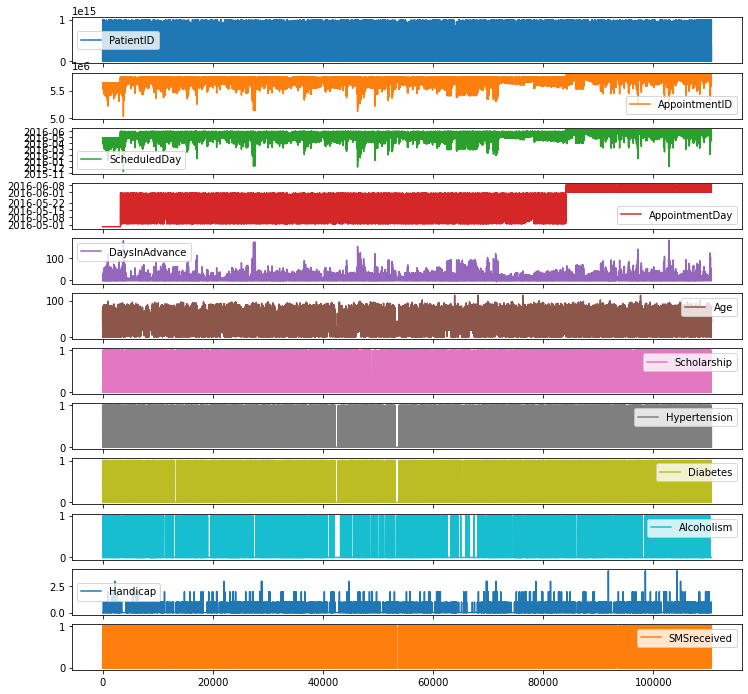

In [30]:
df.plot(subplots=True, figsize=(12,12));

## Day of Week

Total Appointments by Day:  AppointmentDay_DOW
Monday       22714
Tuesday      25640
Wednesday    25867
Thursday     17247
Friday       19019
Saturday        39
Name: PatientID, dtype: int64
% of Appointments by Day:  AppointmentDay_DOW
Monday       20.55
Tuesday      23.20
Wednesday    23.40
Thursday     15.60
Friday       17.21
Saturday      0.04
Name: PatientID, dtype: float64


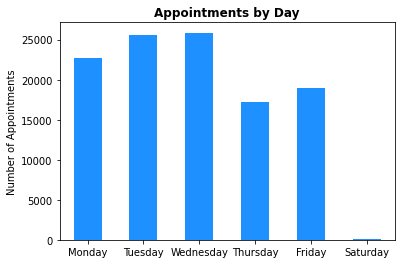

In [101]:
days_ = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

DOW_Appointments = df.groupby('AppointmentDay_DOW')['PatientID'].count()[days_]

DOW_Appointments.plot(kind='bar', color='dodgerblue')
plt.title('Appointments by Day', fontweight='bold')
plt.ylabel('Number of Appointments')
plt.xticks(rotation=0)
plt.xlabel('');

print('Total Appointments by Day: ', DOW_Appointments)
print('% of Appointments by Day: ', round(DOW_Appointments/(110526)*100, 2))

Lets define a function to easily get proportions for each feature.

In [32]:
def Proportions(col, data):

  column_totals = data.groupby([col])['NoShow'].count()
  noshow_totals = data.groupby([col, 'NoShow'])['NoShow'].count()

  pptns = noshow_totals / column_totals

  return pptns

AppointmentDay_DOW  NoShow
Friday              No        0.787739
                    Yes       0.212261
Monday              No        0.793519
                    Yes       0.206481
Saturday            No        0.769231
                    Yes       0.230769
Thursday            No        0.806459
                    Yes       0.193541
Tuesday             No        0.799064
                    Yes       0.200936
Wednesday           No        0.803108
                    Yes       0.196892
Name: NoShow, dtype: float64


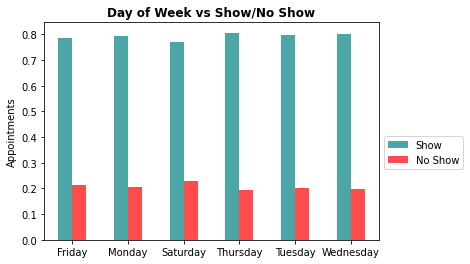

In [33]:
pptns_AppDOW = Proportions('AppointmentDay_DOW', df)

pptns_AppDOW.unstack().plot(kind='bar', color=['teal', 'red'], alpha=0.7)
plt.legend(labels=['Show', 'No Show'], fontsize=10, bbox_to_anchor=(1.0, 0.5));
plt.ylabel('Appointments');
plt.title('Day of Week vs Show/No Show', fontsize=12, fontweight='bold');
plt.xticks(rotation= 0);
plt.xlabel('');

print(pptns_AppDOW)

Above you can see that all days of the week are pretty similar with Saturday being the highest no show rate of 23.08% and Thursday being the lowest no show rate of 19.35%.

## Gender

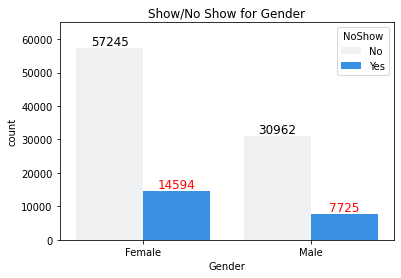

Total Appointments by Gender:  Gender
M    38687
F    71839
Name: PatientID, dtype: int64
% of Appointments by Male:    35.0
% of Appointments by Female:  65.0


In [107]:
ax = sns.countplot(x=df['Gender'], color='dodgerblue', hue=df['NoShow'], data=df)
ax.set_title('Show/No Show for Gender')
x_ticks_labels=['Female', 'Male']
ax.set_xticklabels(x_ticks_labels)
ax.bar_label(ax.containers[0], fontsize=12)
ax.bar_label(ax.containers[1], fontsize=12, color='red')
plt.ylim(0, 65000)
plt.show()

gender = ['M', 'F']
gender_impact = df.groupby('Gender')['PatientID'].count()[gender]

print('Total Appointments by Gender: ', gender_impact)
print('% of Appointments by Male:   ', round(38687/(38687+71839)*100,2))
print('% of Appointments by Female: ', round(71839/(38687+71839)*100,2))


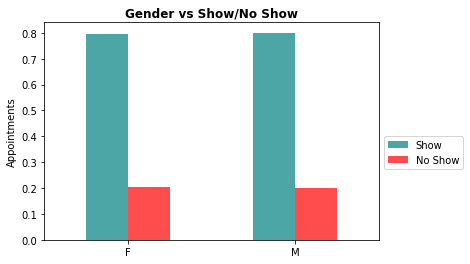

Gender  NoShow
F       No        0.7969
        Yes       0.2031
M       No        0.8003
        Yes       0.1997
Name: NoShow, dtype: float64


In [35]:
pptns_Gender = Proportions('Gender', df)

pptns_Gender.unstack().plot(kind='bar', color=['teal', 'red'], alpha=0.7)
plt.legend(labels=['Show', 'No Show'], fontsize=10, bbox_to_anchor=(1.0, 0.5));
plt.ylabel('Appointments');
plt.title('Gender vs Show/No Show', fontsize=12, fontweight='bold');
plt.xticks(rotation= 0);
plt.xlabel('')
plt.show();

print(round(pptns_Gender, 4))

The total number of appointments for females is 65% where the males is 35%, but the percentage of no shows very similar so I don't see gender as a big impact

## Age

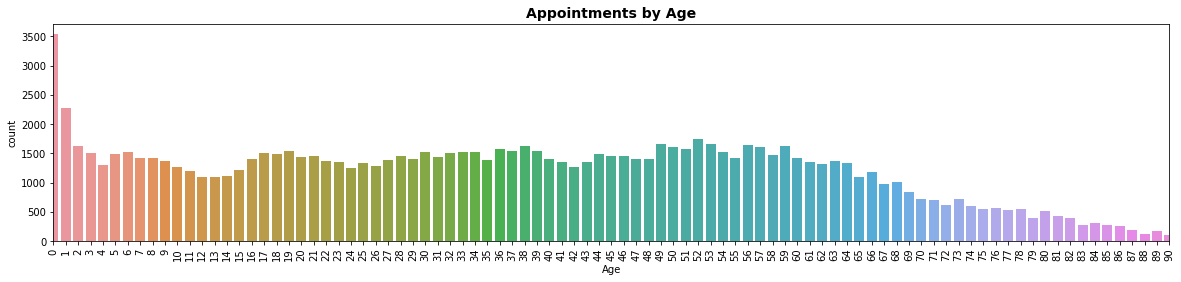

In [104]:
plt.figure(figsize=(20,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df['Age'])
ax.set_title('Appointments by Age', fontsize=14, fontweight='bold')
plt.xlim(0,90)
plt.show()

In [37]:
df['Age'].value_counts()

0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
98        6
115       5
100       4
102       2
99        1
Name: Age, Length: 103, dtype: int64

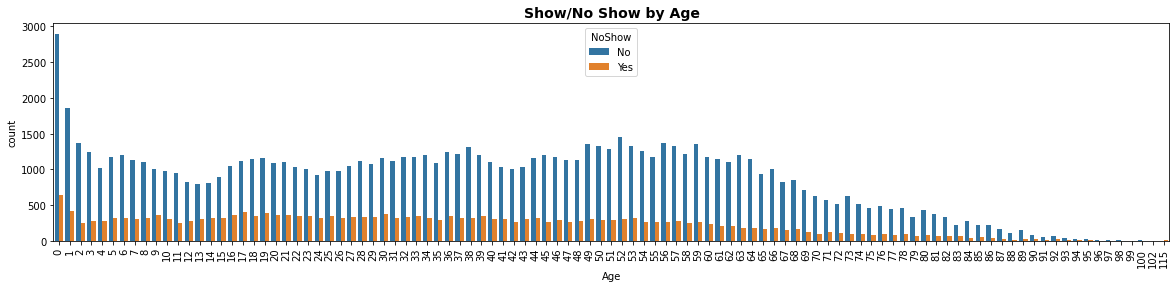

In [38]:
plt.figure(figsize=(20,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df['Age'], hue=df['NoShow'])
ax.set_title('Show/No Show by Age', fontsize=14, fontweight='bold')
plt.show()

Age  NoShow
0    No        0.819441
     Yes       0.180559
1    No        0.817422
     Yes       0.182578
2    No        0.844252
                 ...   
99   No        1.000000
100  No        1.000000
102  No        1.000000
115  No        0.400000
     Yes       0.600000
Name: NoShow, Length: 203, dtype: float64


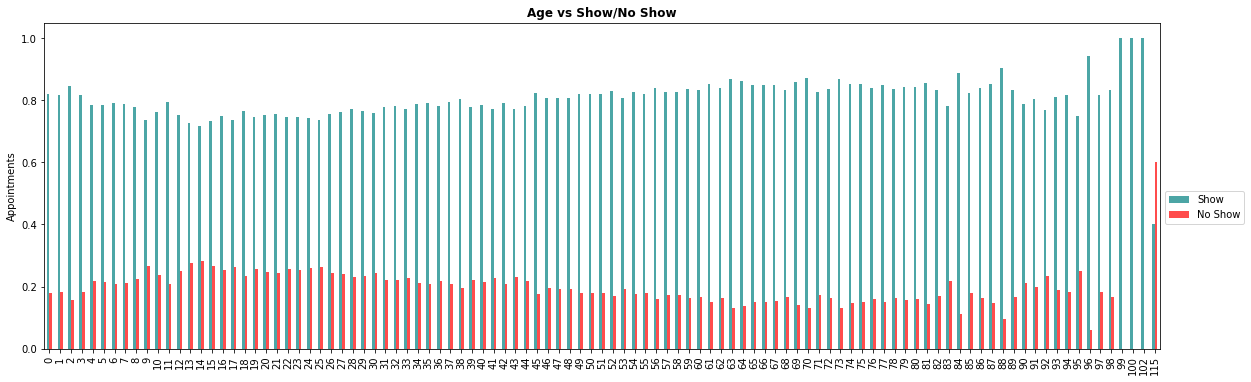

In [39]:
pptns_Age = Proportions('Age', df)

pptns_Age.unstack().plot(kind='bar', color=['teal', 'red'], alpha=0.7, figsize=(20,6))
plt.legend(labels=['Show', 'No Show'], fontsize=10, bbox_to_anchor=(1.0, 0.5));
plt.ylabel('Appointments');
plt.title('Age vs Show/No Show', fontsize=12, fontweight='bold');
plt.xticks(rotation= 90);
plt.xlabel('');

print(pptns_Age)

## Scholarship

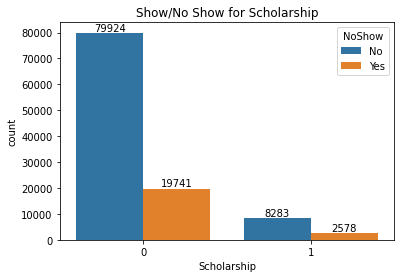

Total Appointments by Scholarship:  Scholarship
0    99665
1    10861
Name: PatientID, dtype: int64
% of Appointments with Scholarship:    9.83
% of Appointments without Scholarship:  90.17


In [40]:
ax = sns.countplot(x=df['Scholarship'], hue=df['NoShow'], data=df)
ax.set_title('Show/No Show for Scholarship')
x_ticks_labels=['0', '1']
ax.set_xticklabels(x_ticks_labels)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

sch = [0, 1]
sch_impact = df.groupby('Scholarship')['PatientID'].count()[sch]

print('Total Appointments by Scholarship: ', sch_impact)
print('% of Appointments with Scholarship:   ', round(10861/(10861+99665)*100,2))
print('% of Appointments without Scholarship: ', round(99665/(10861+99665)*100,2))

Scholarship  NoShow
0            No        0.801926
             Yes       0.198074
1            No        0.762637
             Yes       0.237363
Name: NoShow, dtype: float64


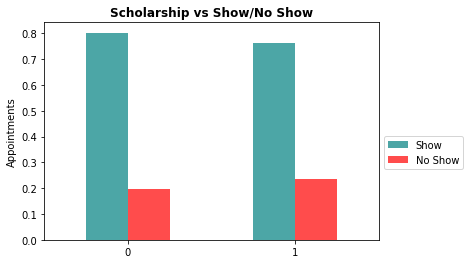

In [41]:
pptns_Scholarship = Proportions('Scholarship', df)

pptns_Scholarship.unstack().plot(kind='bar', color=['teal', 'red'], alpha=0.7, figsize=(6,4))
plt.legend(labels=['Show', 'No Show'], fontsize=10, bbox_to_anchor=(1.0, 0.5));
plt.ylabel('Appointments');
plt.title('Scholarship vs Show/No Show', fontsize=12, fontweight='bold');
plt.xticks(rotation= 0);
plt.xlabel('');

print(pptns_Scholarship)

After looking at the charts here, even though just under 10% of the people receive the scholarship, a much higher percentage of them no show - 19.8% to 23.7%.

## SMSreceived

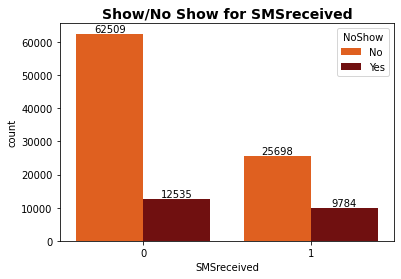

Total Appointments by SMSreceived:  SMSreceived
0    75044
1    35482
Name: PatientID, dtype: int64
% of Appointments with SMSreceived:     32.1
% of Appointments without SMSreceived:  67.9


In [42]:
ax = sns.countplot(x=df['SMSreceived'], hue=df['NoShow'], data=df, palette='gist_heat_r')
ax.set_title('Show/No Show for SMSreceived', fontsize=14, fontweight='bold')
x_ticks_labels=['0', '1']
ax.set_xticklabels(x_ticks_labels)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

plt.show()

sms = [0, 1]
sms_impact = df.groupby('SMSreceived')['PatientID'].count()[sms]

print('Total Appointments by SMSreceived: ', sms_impact)
print('% of Appointments with SMSreceived:    ', round(35482/(75044+35482)*100,2))
print('% of Appointments without SMSreceived: ', round(75044/(75044+35482)*100,2))

This is interesting...it appears that a much higher % of people who received the SMS message did not show up. It seems like it should be the opposite way. Let's investigate this more.

SMSreceived  NoShow
0            No        0.832965
             Yes       0.167035
1            No        0.724255
             Yes       0.275745
Name: NoShow, dtype: float64


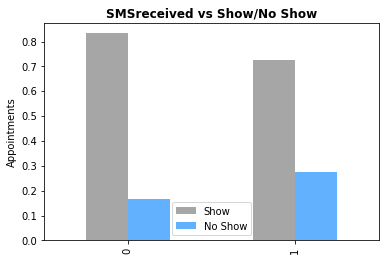

In [109]:
pptns_SMS = Proportions('SMSreceived', df)

pptns_SMS.unstack().plot(kind='bar', color=['grey', 'dodgerblue'], alpha=0.7, figsize=(6,4))
plt.legend(labels=['Show', 'No Show'], fontsize=10);
plt.ylabel('Appointments');
plt.title('SMSreceived vs Show/No Show', fontsize=12, fontweight='bold');
plt.xticks(rotation= 90);
plt.xlabel('');

print(pptns_SMS)

To me it doesn't make sense that the people who received a message about the appointment no showed at a rate of 27.6% vs a rate of 16.7% for the people who didn't receive the message.

## Neighborhood

In [44]:
print(df['Neighborhood'].value_counts())
print(df['Neighborhood'].nunique())

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighborhood, Length: 81, dtype: int64
81


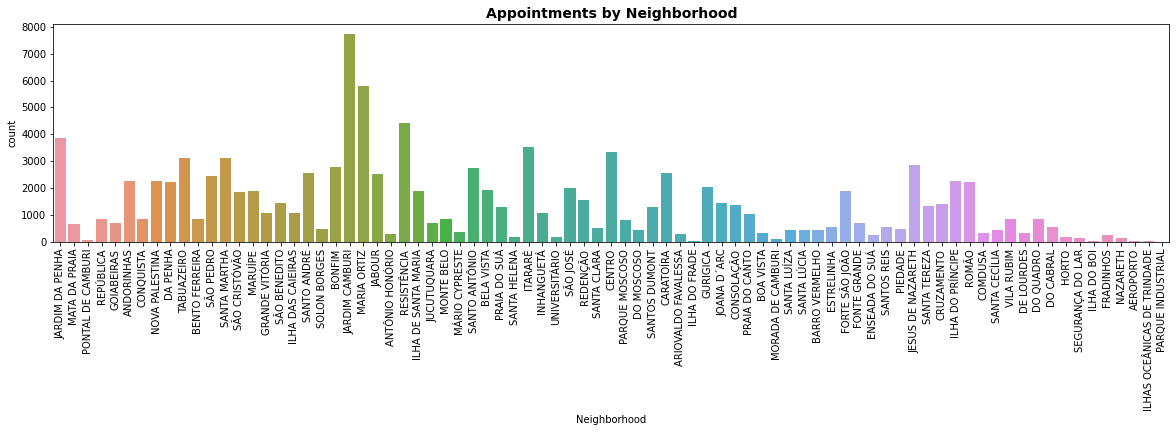

In [45]:
plt.figure(figsize=(20,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df['Neighborhood'])
ax.set_title('Appointments by Neighborhood', fontsize=14, fontweight='bold')
plt.show()

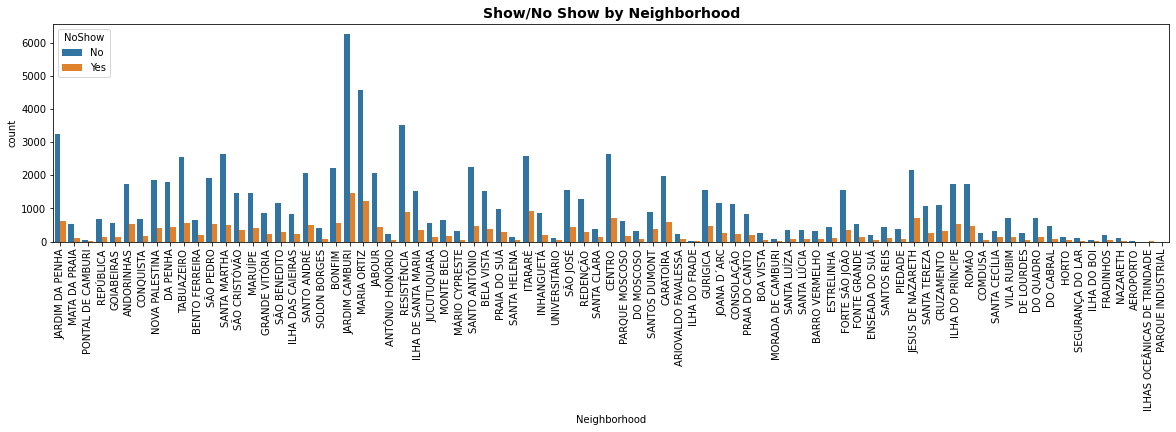

In [46]:
plt.figure(figsize=(20,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df['Neighborhood'], hue=df['NoShow'])
ax.set_title('Show/No Show by Neighborhood', fontsize=14, fontweight='bold')
plt.show()

Neighborhood     NoShow
AEROPORTO        No        0.8750
                 Yes       0.1250
ANDORINHAS       No        0.7697
                 Yes       0.2303
ANTÔNIO HONÓRIO  No        0.8155
                            ...  
TABUAZEIRO       Yes       0.1830
UNIVERSITÁRIO    No        0.7895
                 Yes       0.2105
VILA RUBIM       No        0.8343
                 Yes       0.1657
Name: NoShow, Length: 160, dtype: float64


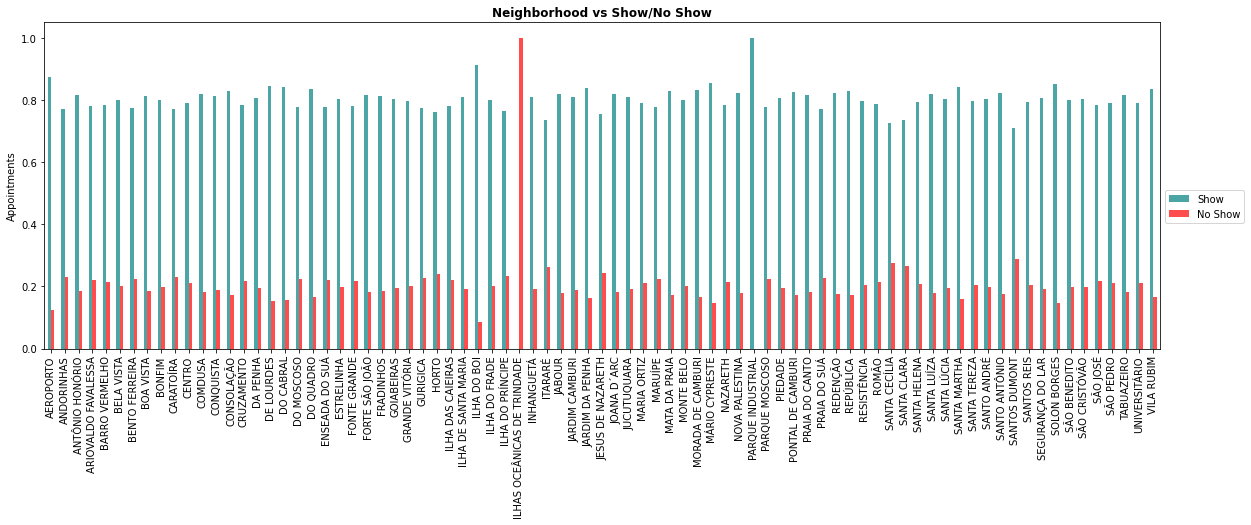

In [47]:
pptns_Neighborhood = Proportions('Neighborhood', df)

pptns_Neighborhood.unstack().plot(kind='bar', color=['teal', 'red'], alpha=0.7, figsize=(20,6))
plt.legend(labels=['Show', 'No Show'], fontsize=10, bbox_to_anchor=(1.0, 0.5));
plt.ylabel('Appointments');
plt.title('Neighborhood vs Show/No Show', fontsize=12, fontweight='bold');
plt.xticks(rotation= 90);
plt.xlabel('');

print(round(pptns_Neighborhood, 4))

## Hypertension

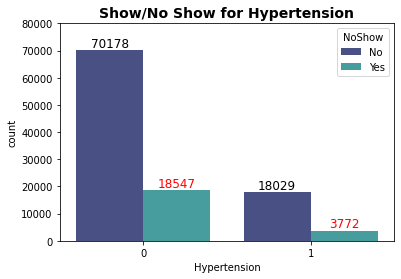

Total Appointments with Hypertension:  Hypertension
0    88725
1    21801
Name: PatientID, dtype: int64
% of Appointments with Hypertension:     19.72
% of Appointments without Hypertension:  80.28


In [48]:
ax = sns.countplot(x=df['Hypertension'], hue=df['NoShow'], data=df, palette='mako')
ax.set_title('Show/No Show for Hypertension', fontsize=14, fontweight='bold')
x_ticks_labels=['0', '1']
ax.set_xticklabels(x_ticks_labels)
ax.bar_label(ax.containers[0], fontsize=12)
ax.bar_label(ax.containers[1], fontsize=12, color='red')
plt.ylim(0,80000)
plt.show()

hyp = [0, 1]
hyp_impact = df.groupby('Hypertension')['PatientID'].count()[hyp]

print('Total Appointments with Hypertension: ', hyp_impact)
print('% of Appointments with Hypertension:    ', round(21801/(88725+21801)*100,2))
print('% of Appointments without Hypertension: ', round(88725/(88725+21801)*100,2))

Hypertension  NoShow
0             No        0.791
              Yes       0.209
1             No        0.827
              Yes       0.173
Name: NoShow, dtype: float64


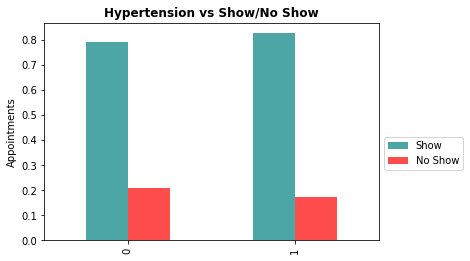

In [49]:
pptns_hyp = Proportions('Hypertension', df)

pptns_hyp.unstack().plot(kind='bar', color=['teal', 'red'], alpha=0.7, figsize=(6,4))
plt.legend(labels=['Show', 'No Show'], fontsize=10, bbox_to_anchor=(1.0, 0.5));
plt.ylabel('Appointments');
plt.title('Hypertension vs Show/No Show', fontsize=12, fontweight='bold');
plt.xticks(rotation= 90);
plt.xlabel('');

print(round(pptns_hyp, 3))

From analyzing the graphs and calculations, only 17.3% of patients with hypertension no show vs 20.9% of clients without hypertension.

## Alcoholism

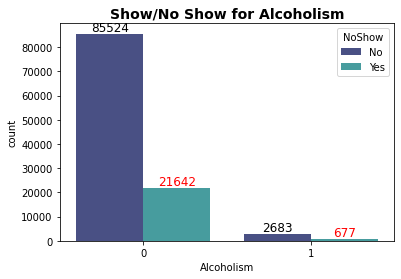

Total Appointments with Alcoholism:  Alcoholism
0    107166
1      3360
Name: PatientID, dtype: int64
% of Appointments with Alcoholism:     3.04
% of Appointments without Alcoholism:  96.96


In [50]:
ax = sns.countplot(x=df['Alcoholism'], hue=df['NoShow'], data=df, palette='mako')
ax.set_title('Show/No Show for Alcoholism', fontsize=14, fontweight='bold')
x_ticks_labels=['0', '1']
ax.set_xticklabels(x_ticks_labels)
ax.bar_label(ax.containers[0], fontsize=12)
ax.bar_label(ax.containers[1], fontsize=12, color='red')

plt.show()

alc = [0, 1]
alc_impact = df.groupby('Alcoholism')['PatientID'].count()[alc]

print('Total Appointments with Alcoholism: ', alc_impact)
print('% of Appointments with Alcoholism:    ', round(3360/(107166+3360)*100,2))
print('% of Appointments without Alcoholism: ', round(107166/(107166+3360)*100,2))

Alcoholism  NoShow
0           No        0.798
            Yes       0.202
1           No        0.799
            Yes       0.201
Name: NoShow, dtype: float64


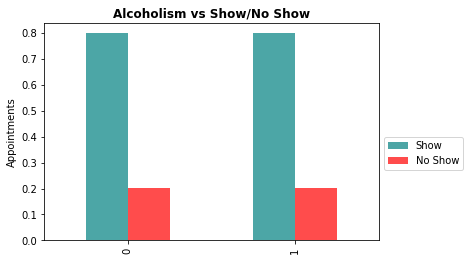

In [51]:
pptns_alc = Proportions('Alcoholism', df)

pptns_alc.unstack().plot(kind='bar', color=['teal', 'red'], alpha=0.7, figsize=(6,4))
plt.legend(labels=['Show', 'No Show'], fontsize=10, bbox_to_anchor=(1.0, 0.5));
plt.ylabel('Appointments');
plt.title('Alcoholism vs Show/No Show', fontsize=12, fontweight='bold');
plt.xticks(rotation= 90);
plt.xlabel('');

print(round(pptns_alc, 3))

Since only 3.04% of patients have alcoholism and the no show rate both patients with and without alcoholism are so close, I am not going to look at alcoholism anymore.

## Handicap

In [52]:
df['Handicap'].value_counts()

0    108285
1      2042
2       183
3        13
4         3
Name: Handicap, dtype: int64

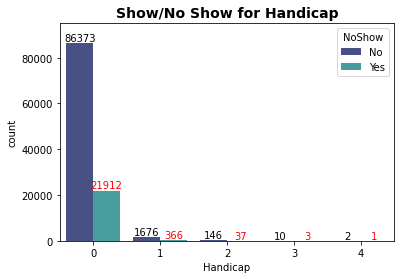

Total Appointments with Handicap:  Handicap
0    108285
1      2042
2       183
3        13
4         3
Name: PatientID, dtype: int64
% of Appointments with Handicap 1-4:  2.03
% of Appointments with Handicap 1:    1.85
% of Appointments with Handicap 2:    0.17
% of Appointments with Handicap 3:    0.01
% of Appointments with Handicap 4:    0.003
% of Appointments with No Handicap:   97.97


In [53]:
ax = sns.countplot(x=df['Handicap'], hue=df['NoShow'], data=df, palette='mako')
ax.set_title('Show/No Show for Handicap', fontsize=14, fontweight='bold')
x_ticks_labels=['0', '1', '2', '3','4']
ax.set_xticklabels(x_ticks_labels)
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10, color='red')
plt.ylim(0,95000)
plt.show()

handi = [0, 1, 2, 3, 4]
handi_impact = df.groupby('Handicap')['PatientID'].count()[handi]

print('Total Appointments with Handicap: ', handi_impact)
print('% of Appointments with Handicap 1-4: ', round((2042+183+13+3)/(108285+2042+183+13+3)*100,2))
print('% of Appointments with Handicap 1:   ', round(2042/(108285+2042+183+13+3)*100,2))
print('% of Appointments with Handicap 2:   ', round(183/(108285+2042+183+13+3)*100,2))
print('% of Appointments with Handicap 3:   ', round(13/(108285+2042+183+13+3)*100,2))
print('% of Appointments with Handicap 4:   ', round(3/(108285+2042+183+13+3)*100,3))
print('% of Appointments with No Handicap:  ', round(108285/(108285+2042+183+13+3)*100,2))

Handicap  NoShow
0         No        0.798
          Yes       0.202
1         No        0.821
          Yes       0.179
2         No        0.798
          Yes       0.202
3         No        0.769
          Yes       0.231
4         No        0.667
          Yes       0.333
Name: NoShow, dtype: float64


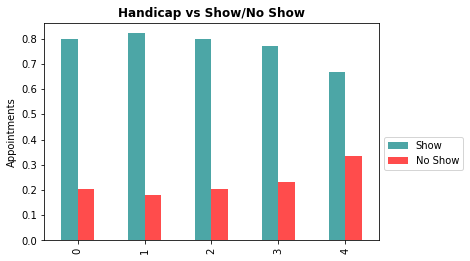

In [54]:
pptns_handi = Proportions('Handicap', df)

pptns_handi.unstack().plot(kind='bar', color=['teal', 'red'], alpha=0.7, figsize=(6,4))
plt.legend(labels=['Show', 'No Show'], fontsize=10, bbox_to_anchor=(1.0, 0.5));
plt.ylabel('Appointments');
plt.title('Handicap vs Show/No Show', fontsize=12, fontweight='bold');
plt.xticks(rotation= 90);
plt.xlabel('');

print(round(pptns_handi, 3))

From no handicap to handicap 1-3, there is a minimal difference. Handicap 4 has a higher no show rate, but there are only 3 patients with this so it is irrelevant.

Since only 3.03% of all the patients have a handicap and the % of no shows isn't that different than the patients without a handicap, I feel that this can be ignored during testing.

## Diabetes

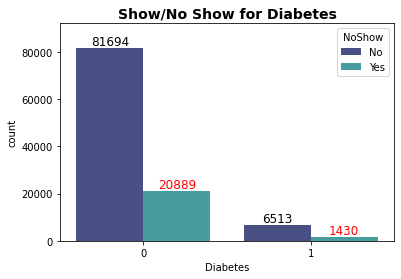

Total Appointments with Diabetes:  Diabetes
0    102583
1      7943
Name: PatientID, dtype: int64
% of Appointments with Diabetes:     7.19
% of Appointments without Diabetes:  92.81


In [55]:
ax = sns.countplot(x=df['Diabetes'], hue=df['NoShow'], data=df, palette='mako')
ax.set_title('Show/No Show for Diabetes', fontsize=14, fontweight='bold')
x_ticks_labels=['0', '1']
ax.set_xticklabels(x_ticks_labels)
ax.bar_label(ax.containers[0], fontsize=12)
ax.bar_label(ax.containers[1], fontsize=12, color='red')
plt.ylim(0,92000)
plt.show()

dia = [0, 1]
dia_impact = df.groupby('Diabetes')['PatientID'].count()[dia]

print('Total Appointments with Diabetes: ', dia_impact)
print('% of Appointments with Diabetes:    ', round(7943/(102583+7943)*100,2))
print('% of Appointments without Diabetes: ', round(102583/(102583+7943)*100,2))

Diabetes  NoShow
0         No        0.796
          Yes       0.204
1         No        0.820
          Yes       0.180
Name: NoShow, dtype: float64


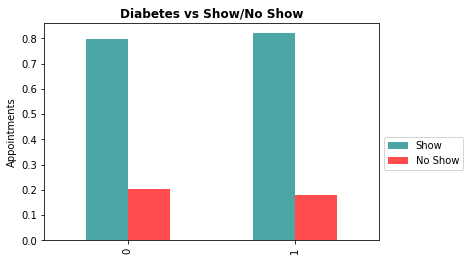

In [56]:
pptns_dia = Proportions('Diabetes', df)

pptns_dia.unstack().plot(kind='bar', color=['teal', 'red'], alpha=0.7, figsize=(6,4))
plt.legend(labels=['Show', 'No Show'], fontsize=10, bbox_to_anchor=(1.0, 0.5));
plt.ylabel('Appointments');
plt.title('Diabetes vs Show/No Show', fontsize=12, fontweight='bold');
plt.xticks(rotation= 90);
plt.xlabel('');

print(round(pptns_dia, 3))

Patients with diabetes no show at a slightly lower rate of 18% versus 20.4% of patients without diabetes.

# **Data Modeling**

Here I am going to run a variety of classification analyses to determine which tecnique is best for predicting the outcome (Show/NoShow).

After doing data exploration, I have determined that some of the features are not necessary
* Alcoholism
* Handicap
* Diabetes

## One Hot Encoding

In [57]:
df2 = df.copy()
df2.head(2)

,PatientID,AppointmentID,Gender,ScheduledDay,ScheduledDay_DOW,AppointmentDay,AppointmentDay_DOW,DaysInAdvance,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSreceived,NoShow
0,29872499824296,5642903,F,2016-04-29,Friday,2016-04-29,Friday,0,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,Friday,2016-04-29,Friday,0,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [58]:
def change(col):
    if col=='Yes':
        return 1
    elif col=='No':
        return 0

df2['NoShow'] = df2['NoShow'].apply(change)
df2.head(2)

,PatientID,AppointmentID,Gender,ScheduledDay,ScheduledDay_DOW,AppointmentDay,AppointmentDay_DOW,DaysInAdvance,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSreceived,NoShow
0,29872499824296,5642903,F,2016-04-29,Friday,2016-04-29,Friday,0,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,558997776694438,5642503,M,2016-04-29,Friday,2016-04-29,Friday,0,56,JARDIM DA PENHA,0,0,0,0,0,0,0


In [59]:
le = LabelEncoder()

df2['Male1_Female0'] =le.fit_transform(df2['Gender'])
df2['DOW'] = le.fit_transform(df2['AppointmentDay_DOW'])
df2['Neigh'] = le.fit_transform(df2['Neighborhood'])
df2.head(2)

,PatientID,AppointmentID,Gender,ScheduledDay,ScheduledDay_DOW,AppointmentDay,AppointmentDay_DOW,DaysInAdvance,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSreceived,NoShow,Male1_Female0,DOW,Neigh
0,29872499824296,5642903,F,2016-04-29,Friday,2016-04-29,Friday,0,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,0,39
1,558997776694438,5642503,M,2016-04-29,Friday,2016-04-29,Friday,0,56,JARDIM DA PENHA,0,0,0,0,0,0,0,1,0,39


In [60]:
print(df2['AppointmentDay_DOW'].value_counts())
print(df2['DOW'].value_counts())

Wednesday    25867
Tuesday      25640
Monday       22714
Friday       19019
Thursday     17247
Saturday        39
Name: AppointmentDay_DOW, dtype: int64
5    25867
4    25640
1    22714
0    19019
3    17247
2       39
Name: DOW, dtype: int64


In [61]:
print(df2['Neighborhood'].value_counts())
print(df2['Neigh'].value_counts())

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighborhood, Length: 81, dtype: int64
38    7717
43    5805
59    4431
39    3877
36    3514
      ... 
31      35
32      10
0        8
34       2
51       1
Name: Neigh, Length: 81, dtype: int64


In [62]:
df2 = df2.drop(['PatientID', 
                'AppointmentID', 
                'ScheduledDay', 
                'ScheduledDay_DOW', 
                'AppointmentDay', 
                'AppointmentDay_DOW', 
                'Diabetes', 
                'Alcoholism', 
                'Handicap', 
                'Gender', 
                'Neighborhood'], axis=1)

df2.head(2)

,DaysInAdvance,Age,Scholarship,Hypertension,SMSreceived,NoShow,Male1_Female0,DOW,Neigh
0,0,62,0,1,0,0,0,0,39
1,0,56,0,0,0,0,1,0,39


## Decision Tree

In [63]:
X_dt = df2[['DaysInAdvance', 'Age', 'Scholarship', 'Hypertension', 'SMSreceived', 'Male1_Female0', 'DOW', 'Neigh']]
y_dt = df2['NoShow']

X_dt_train, X_dt_test, y_dt_train, y_dt_test = train_test_split(X_dt, y_dt, test_size=0.2)

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import tree

sc = StandardScaler()
X_dt_train = sc.fit_transform(X_dt_train)
X_dt_test = sc.transform(X_dt_test)

In [65]:
decision_tree = DecisionTreeClassifier(criterion='entropy')
decision_tree.fit(X_dt_train, y_dt_train)
y_pred = decision_tree.predict(X_dt_test)
cm = confusion_matrix(y_dt_test,y_pred)
print(cm)
print('Decision Tree Accuracy Score: ', accuracy_score(y_dt_test,y_pred))

[[14556  3068]
 [ 2935  1547]]
Decision Tree Accuracy Score:  0.7284447661268434


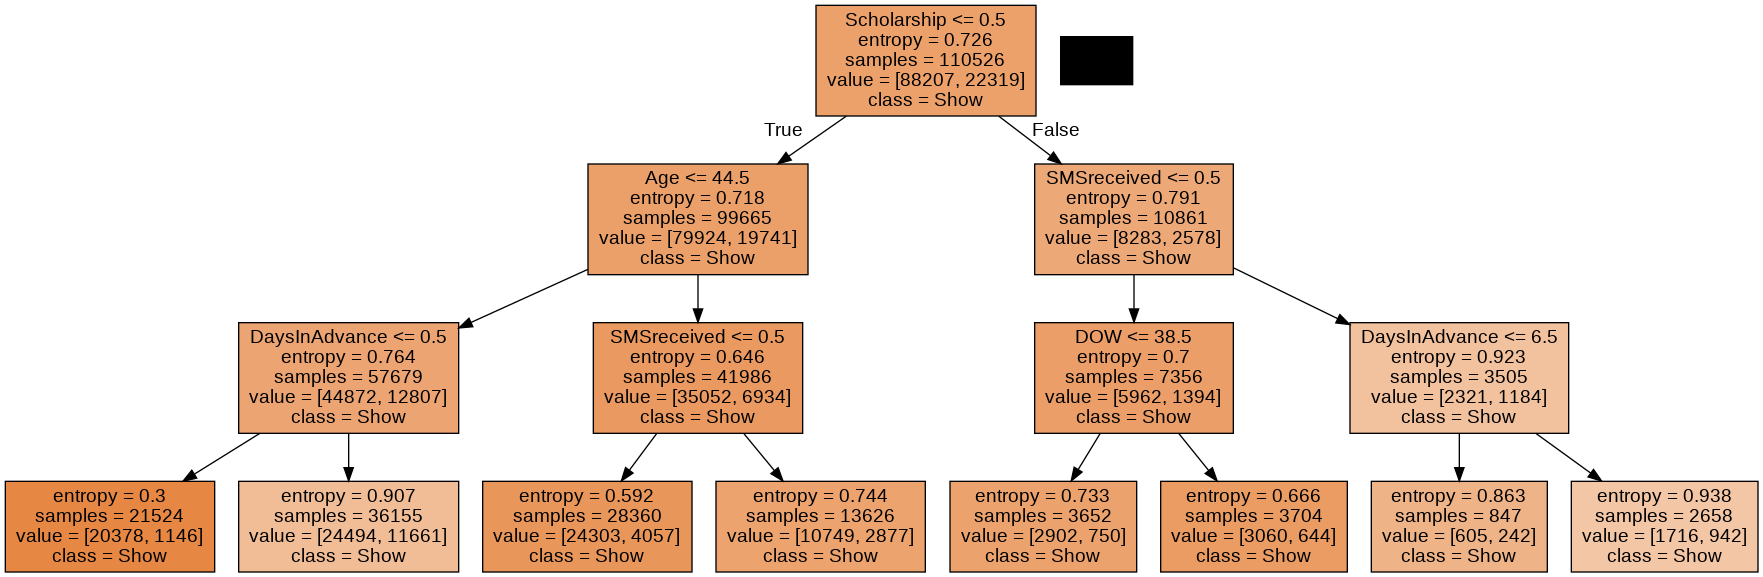

In [66]:
import pydotplus
from IPython.display import Image

# Initialize and train the tree

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=2,
    max_depth=3
)
decision_tree.fit(X_dt, y_dt)

# Render the tree
features = df2.columns
features = features[0:-1]

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=features,
    class_names=['Show', 'No Show'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [67]:
print('Accuracy:  ', round(decision_tree.score(X_dt_test, y_dt_test),5))

Accuracy:   0.79725


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


## Support Vector Machine

In [68]:
list(df2.columns)

['DaysInAdvance',
 'Age',
 'Scholarship',
 'Hypertension',
 'SMSreceived',
 'NoShow',
 'Male1_Female0',
 'DOW',
 'Neigh']

In [69]:
from sklearn.svm import SVR

svr = SVR()

X_svr = df2[['DaysInAdvance', 'Age', 'DOW', 'Neigh']]
y_svr = df2['NoShow']

X_svr_train, X_svr_test, y_svr_train, y_svr_test = train_test_split(X_svr, y_svr, test_size = 0.20)

In [70]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVC(kernel='poly', degree=8, gamma="auto")
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto")
    elif ktype == 2:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto")
    elif ktype == 3:
        # Linear kernal
        return SVC(kernel='linear', gamma="auto")

The runtime to fit the model takes too long so I will not be moving forward with this.

## Random Forest

In [71]:
X_rf = df2[['DaysInAdvance', 'Age', 'Scholarship', 'Hypertension', 'SMSreceived', 'Male1_Female0', 'DOW', 'Neigh']]
y_rf = df2['NoShow']

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

In [72]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)

print(f'{cross_val_score(rfc, X_rf, y_rf, cv=5)}\n')

[0.76517688 0.76227098 0.75209229 0.76684008 0.7707306 ]



<AxesSubplot:>

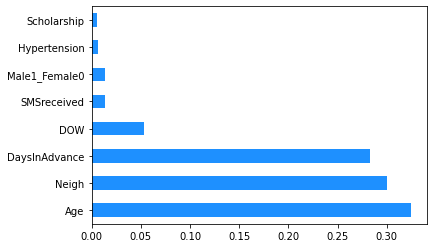

In [73]:
rfc.fit(X_rf, y_rf)

feat_importances = pd.Series(rfc.feature_importances_, index=X_rf.columns)
feat_importances.nlargest(20).plot(kind='barh', color=['dodgerblue'])

You can see that only 4 of the features have a significant impact on the out-of-sample predictions:
* DOW
* DaysInAdvance
* Neigh
* Age 

In [74]:
rf = RandomForestClassifier(criterion='entropy', 
                            n_estimators=100, 
                            random_state=42, 
                            max_depth=2, 
                            max_features=2,  
                            )
rf.fit(X_rf_train, y_rf_train)
y_pred_rf = rf.predict(X_rf_test)
cm_rf = confusion_matrix(y_rf_test,y_pred_rf)
print(cm_rf)
print(accuracy_score(y_rf_test,y_pred_rf))

[[17715     0]
 [ 4391     0]]
0.8013661449380258


In [75]:
params={'n_estimators':[10,20], 'max_depth':[None, 5], 'min_samples_split':[2,3]}
rfc = RandomForestClassifier(random_state=42)
clf_grid = GridSearchCV(rfc, params, cv=5, n_jobs=-1, verbose=1)
clf_grid.fit(X_rf, y_rf)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.7980746612632974


In [76]:
from sklearn.metrics import precision_score, recall_score

rfc.fit(X_rf, y_rf)
print('Accuracy:  ', round(rfc.score(X_rf_test, y_rf_test),5))
y_rf_pred = rfc.predict(X_rf_test)
print('Precision: ', round(precision_score(y_rf_test,y_rf_pred),5))
print('Recall :   ', round(recall_score(y_rf_test,y_rf_pred),5))

Accuracy:   0.9763
Precision:  0.97032
Recall :    0.90845


## Gradient Boosting

I am only going to use the top 4 features for this analysis.

In [77]:
import itertools

In [78]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [79]:
X_gb = df2[['DaysInAdvance', 'Age', 'DOW', 'Neigh']]
y_gb = df2['NoShow']

X_gb_train, X_gb_test, y_gb_train, y_gb_test = train_test_split(X_gb, y_gb, test_size=0.2, random_state=42)

Parameters For Tuning:

* learning_rate
* max_depth
* n_estimators
* loss
* subsample
* min_samples_split
* max_features

Best

In [80]:
params = {'n_estimators': 100,
          'max_depth': 4,
          'loss': 'deviance', 
          'learning_rate':0.4, 
          'subsample': 0.4, 
          'min_samples_split': 50, 
          'max_features': 4}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_gb_train, y_gb_train)

predict_train = clf.predict(X_gb_train)
predict_test = clf.predict(X_gb_test)

Confusion matrix, without normalization


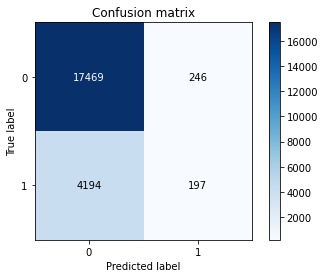

In [81]:
cm = confusion_matrix(y_gb_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

In [82]:
print('Accuracy:  ', round(clf.score(X_gb_test, y_gb_test),5))
y_gb_pred = clf.predict(X_gb_test)
print('Precision: ', round(precision_score(y_gb_test,y_gb_pred),5))
print('Recall :   ', round(recall_score(y_gb_test,y_gb_pred),5))

Accuracy:   0.79915
Precision:  0.4447
Recall :    0.04486


Testing

In [83]:
params = {'n_estimators': 100,
          'max_depth': 4,
          'loss': 'exponential', 
          'learning_rate':0.4, 
          'subsample': 0.4, 
          'min_samples_split': 5, 
          'max_features': 4}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_gb_train, y_gb_train)

predict_train = clf.predict(X_gb_train)
predict_test = clf.predict(X_gb_test)

Confusion matrix, without normalization


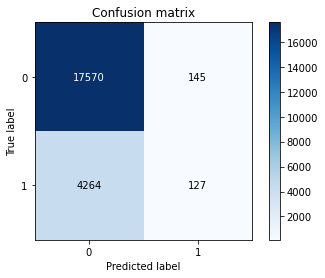

In [84]:
cm = confusion_matrix(y_gb_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

In [85]:
print('Accuracy:  ', round(clf.score(X_gb_test, y_gb_test),5))
y_gb_pred = clf.predict(X_gb_test)
print('Precision: ', round(precision_score(y_gb_test,y_gb_pred),5))
print('Recall :   ', round(recall_score(y_gb_test,y_gb_pred),5))

Accuracy:   0.80055
Precision:  0.46691
Recall :    0.02892


# **After cleaning, engineering, visualizing and modeling, I have decided that the best method for this analysis is Random Forest because of the high Accuracy, Precision and Recall.**